In [1]:
%load_ext autoreload
%autoreload 2

import ncem

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
from scipy.stats import ttest_rel, ttest_ind

usr = !echo $USER
grid_search_dir = '.'
datadir = '.'

In [2]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Interaction model

##  Figure 1 (d): Modeling cell communication as spatial cell state dependencies.

210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH: loaded 9 runs with 3-fold cross validation
210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH: loaded 72 runs with 3-fold cross validation
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_PATIENT_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_PATIENT_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_PATIENT_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_PATIENT_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_PATIENT_1'], given was ['INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['INTERACTIONS_MAX_NODES_PATIENT_1'], gi

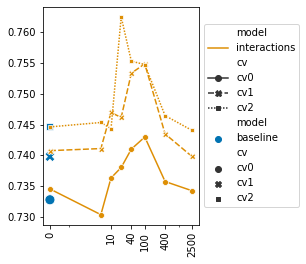

In [3]:
gs_linear = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=[
        "210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH",
        "210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH"
    ],
    lateral_resolution = 0.5
)
gs_linear.load_gs()

gs_linear.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="model",
    graph_model_class='interactions',
    baseline_model_class='interactions_baseline',
    rename_levels = [
        ("model", {
            "INTERACTIONS_MAX_NODES_PATIENT_1": "interactions",
            "INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1": "baseline",
        })
    ],
    plot_mode = 'lineplot',
    palette = {"baseline": "C0", "interactions": "C1"},
    xticks=[ 0,  10, 40, 100, 400, 2500],
)

## Paired t-test between baseline model and best spatial model

In [4]:
test_id_interaction = gs_linear.get_best_model_id(
    subset_hyperparameters=[("model", "INTERACTIONS_MAX_NODES_PATIENT_1")],
)
interaction_test_r2 = np.array(
    gs_linear.summary_table[gs_linear.summary_table["run_id"] ==test_id_interaction]['test_r_squared_linreg']
)
test_id_baseline = gs_linear.get_best_model_id(
    subset_hyperparameters=[("model", "INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1")],
)
baseline_test_r2 = np.array(
    gs_linear.summary_table[gs_linear.summary_table["run_id"] ==test_id_baseline]['test_r_squared_linreg']
)

print(ttest_rel(interaction_test_r2, baseline_test_r2))

Ttest_relResult(statistic=7.099563973069123, pvalue=0.019268214525060827)


## Supp. Fig. 4 (b): Length scales of dependencies for different target cell-types.

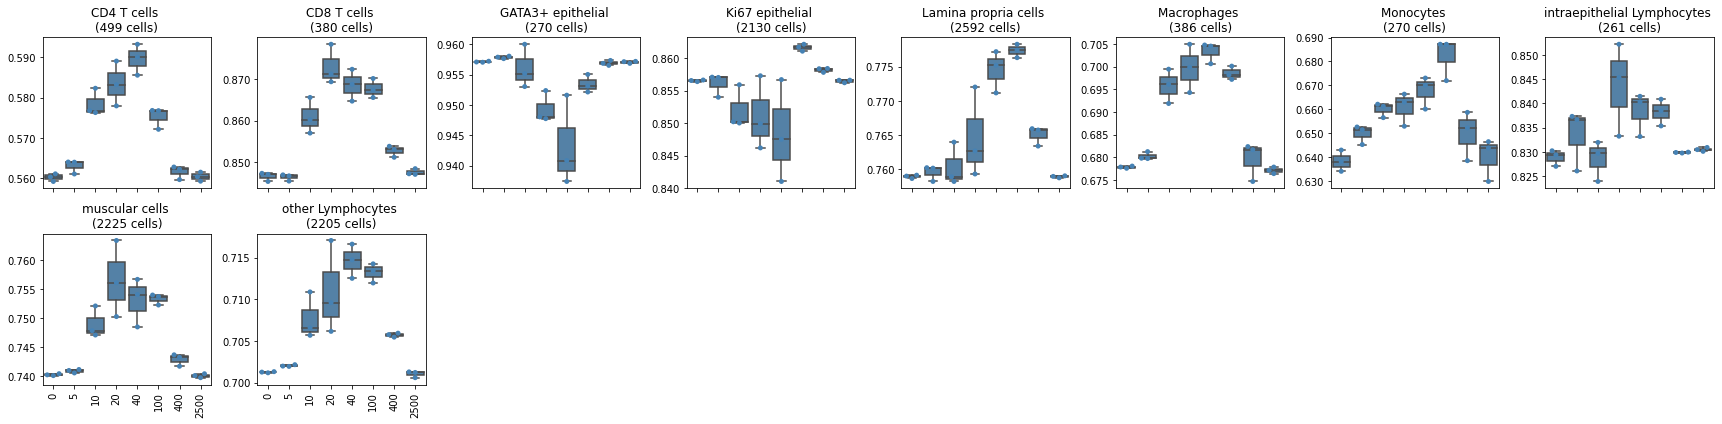

In [5]:
gs_linear.load_target_cell_evaluation()
gs_linear.plot_target_cell_evaluation(
    metric_show="r_squared_linreg",
    metric_select="r_squared_linreg",
    param_x="um_radius",
)

## Interpreter

In [6]:
clm = ncem.interpretation.InterpreterInteraction()
clm.load_model(
    results_path=grid_search_dir,
    gs_id="210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH",
    cv_idx=0,
    model_id=test_id_interaction,
)
clm.get_data_again(data_path=datadir + "busch/", data_origin="jarosch")
clm.split_data_byidx_again(cv_idx=0)
clm.init_model_again()
clm.load_weights_again()

clm.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 144, 1, 0, 1)})

210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH: loaded 72 runs with 3-fold cross validation
cross-validation selected: cv0
loaded model 210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md5_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l24_l14_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
Loading data from raw files
registering celldata
collecting image-wise celldata


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]

adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 103.034519
cross-validation selected: cv0

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f315daee340> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f315dc49610>).

Two checkpoint references resolved to different objects (<ncem.models.layers.output_layers.LinearOutput object at 0x7f315d154a60> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f315cf763d0>).
setting reinitialized layer weights to layer weights from model 210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md5_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l24_l14_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21


In [7]:
lm = ncem.interpretation.InterpreterInteraction()
lm.load_model(
    results_path=grid_search_dir,
    gs_id="210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH",
    cv_idx=0,
)
lm.get_data_again(data_path=datadir + "busch/", data_origin="jarosch"
)
lm.split_data_byidx_again(cv_idx=0)
lm.init_model_again()
lm.load_weights_again()

lm.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 144, 1, 0, 1)})

210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH: loaded 9 runs with 3-fold cross validation
cross-validation selected: cv0
loaded model 210414_interactions_baseline_none_nodes_patient_1_busch_adam_lr1_agrFalse_predecTrue_bsS_md0_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l16_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
Loading data from raw files
registering celldata
collecting image-wise celldata


100%|██████████| 2/2 [00:00<00:00, 16.82it/s]

adding graph-level covariates
Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 0.000000
cross-validation selected: cv0


setting reinitialized layer weights to layer weights from model 210414_interactions_baseline_none_nodes_patient_1_busch_adam_lr1_agrFalse_predecTrue_bsS_md0_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l16_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21


## Supp. Fig. 8 (c,f): Attributing cell heterogeneity to niche composition in CD8 Tcells in inflamed colon. 

In [8]:
adata_img, adata_CD8Tcells = clm.target_cell_relative_performance(
    image_key='Area_1',
    baseline_model=lm,
    target_cell_type='CD8 T cells',
    n_neighbors=22,
    n_pcs=None,
)

  0%|          | 0/4861 [00:00<?, ?it/s]

ATTENTION: specifying reinit_n_eval will change class argument n_eval_nodes_per_graph from 100 to 1


100%|██████████| 4861/4861 [03:44<00:00, 21.69it/s]


n cells:  234
CD8 T cells 0    74
CD8 T cells 1    58
CD8 T cells 2    41
CD8 T cells 3    37
CD8 T cells 4    24
Name: CD8 T cells substates, dtype: int64


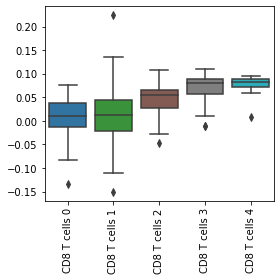

In [9]:
clm.plot_substate_performance(adata=adata_CD8Tcells, target_cell_type='CD8 T cells')

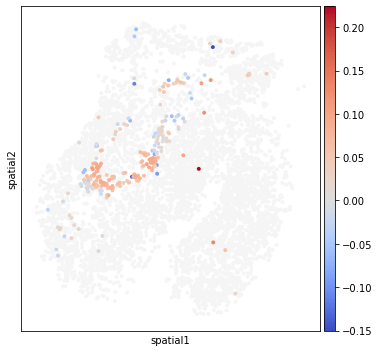

In [10]:
clm.plot_spatial_relative_performance(adata=adata_img, target_cell_type='CD8 T cells')

## Supp. Fig. 10: Parameter significance for chip cytometry – colon data set.

In [12]:
clm = ncem.interpretation.InterpreterInteraction()
clm.load_model(
    results_path=grid_search_dir,
    gs_id="210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH",
    cv_idx=0,
    model_id=test_id_interaction,
)
clm.get_data_again(data_path=datadir + "busch/", data_origin="jarosch")
clm.split_data_byidx_again(cv_idx=0)
clm.init_model_again()
clm.load_weights_again()

clm.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 144, 1, 0, 1)})

210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH: loaded 72 runs with 3-fold cross validation
cross-validation selected: cv0
loaded model 210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md5_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l24_l14_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 103.034519
cross-validation selected: cv0

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f311df269a0> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f311c7da040>).

Two checkpoint references resolved to different objects (<ncem.models.layers.output_layers.LinearOutput object at 0x7f311c47d100> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f311df3d190>).


setting reinitialized layer weights to layer weights from model 210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md5_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l24_l14_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21


In [13]:
lm = ncem.interpretation.InterpreterInteraction()
lm.load_model(
    results_path=grid_search_dir,
    gs_id="210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH",
    cv_idx=0,
)
lm.get_data_again(data_path=datadir + "busch/", data_origin="jarosch"
)
lm.split_data_byidx_again(cv_idx=0)
lm.init_model_again()
lm.load_weights_again()

lm.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 144, 1, 0, 1)})

210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH: loaded 9 runs with 3-fold cross validation
cross-validation selected: cv0
loaded model 210414_interactions_baseline_none_nodes_patient_1_busch_adam_lr1_agrFalse_predecTrue_bsS_md0_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l16_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 0.000000
cross-validation selected: cv0
setting reinitialized layer weights to layer weights from model 210414_interactions_baseline_none_nodes_patient_1_busch_adam_lr1_agrFalse_predecTrue_bsS_md0_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l16_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21


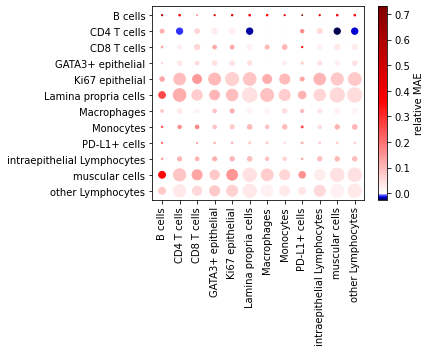

In [14]:
clm.relative_performance_grid(
    image_keys = clm.img_keys_train,
    nodes_idx=clm.nodes_idx_train,
    base_interpreter = lm,
    metric='mae',
    scale_node_frequencies=10,
)

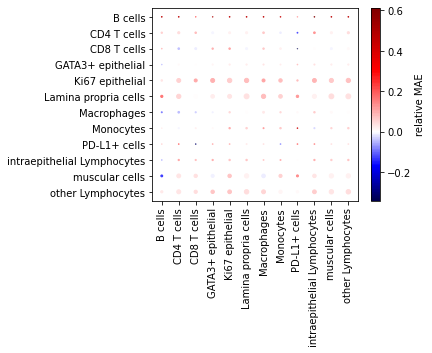

In [15]:
clm.relative_performance_grid(
    image_keys = clm.img_keys_test,
    nodes_idx=clm.nodes_idx_test,
    base_interpreter = lm,
    metric='mae',
    scale_node_frequencies=10,
)

In [16]:
clm = ncem.interpretation.InterpreterInteraction()
clm.load_model(
    results_path=grid_search_dir,
    gs_id="210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH",
    cv_idx=1,
    model_id='210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md4_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l1N_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21',
)
clm.get_data_again(data_path=datadir + "busch/", data_origin="jarosch")
clm.split_data_byidx_again(cv_idx=1)
clm.init_model_again()
clm.load_weights_again()
clm.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 144, 1, 0, 1)})

210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH: loaded 72 runs with 3-fold cross validation
cross-validation selected: cv1
loaded model 210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md4_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l1N_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21
Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 18.522793
cross-validation selected: cv1

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f311c421dc0> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f313c0bc760>).

Two checkpoint references resolved to different objects (<ncem.models.layers.output_layers.LinearOutput object at 0x7f315cf2c790> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f313f7ecf40>).
setting reinitialized layer weights to layer weights from model 210414_interactions_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md4_tk4_n100_fsstandard_ldi1_ei1_di1_ede1_dde1_dr1_l2N_l1N_COND_cde1_cbTrue_cdi1_cdr1_cnh1_cl21


In [17]:
interaction_params, bool_significance, significance = clm.interaction_significance(
    image_keys = clm.img_keys_train,
    nodes_idx=clm.nodes_idx_train,
)

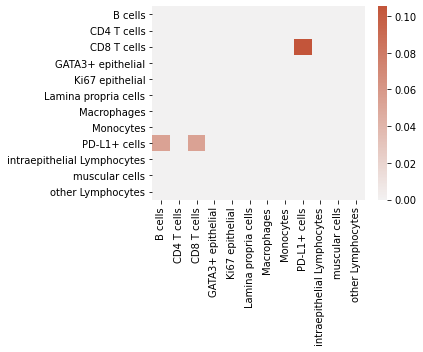

In [18]:
sig_df = pd.DataFrame(
    np.mean(bool_significance, axis=-1), 
    columns=list(clm.node_type_names.values()),
    index=list(clm.node_type_names.values())
)
plt.ioff()   
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(sig_df, cmap=cmap, center=0)
plt.tight_layout()
plt.show()

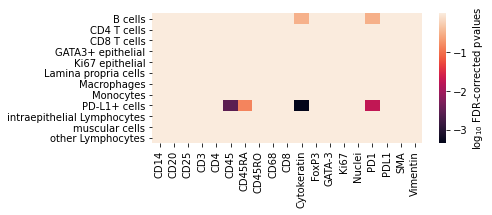

In [19]:
cd8_T_cells_significance = significance[2, :, :]
cd8_T_cells_significance = pd.DataFrame(
    np.log10(cd8_T_cells_significance), 
    index=list(clm.node_type_names.values()),
    columns=list(clm.node_feature_names)
)
plt.ioff()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
sns.heatmap(
    cd8_T_cells_significance,
    cbar_kws={'label': "$\log_{10}$ FDR-corrected pvalues"},
)
plt.tight_layout()
plt.show()

In [20]:
print('PD1 coefficient:', interaction_params.transpose((1,2,0))[2, :, :][8, :][-4])

PD1 coefficient: -1.9221641


In [21]:
print('PD1 corrected pvalue:', significance[2, :, :][8, :][-4])

PD1 corrected pvalue: 0.017724016462865443


# Linear model

## Supp. Fig. 3: Linear models for spatial cell state dependencies.

210520_LINEAR_BASELINE_MAX_NODES_PATIENT_1_BUSCH: loaded 1 runs with 3-fold cross validation
210520_LINEAR_MAX_NODES_PATIENT_1_BUSCH: loaded 8 runs with 3-fold cross validation
210521_LINEAR_MAX_NODES_PATIENT_1_BUSCH: loaded 70 runs with 3-fold cross validation
subset was empty, available values for model are ['LINEAR_MAX_NODES_PATIENT_1'], given was ['LINEAR_BASELINE_MAX_NODES_PATIENT_1']
subset was empty, available values for model are ['LINEAR_MAX_NODES_PATIENT_1'], given was ['LINEAR_BASELINE_MAX_NODES_PATIENT_1']
subset was empty, available values for model are ['LINEAR_MAX_NODES_PATIENT_1'], given was ['LINEAR_BASELINE_MAX_NODES_PATIENT_1']
subset was empty, available values for model are ['LINEAR_MAX_NODES_PATIENT_1'], given was ['LINEAR_BASELINE_MAX_NODES_PATIENT_1']
subset was empty, available values for model are ['LINEAR_MAX_NODES_PATIENT_1'], given was ['LINEAR_BASELINE_MAX_NODES_PATIENT_1']
subset was empty, available values for model are ['LINEAR_MAX_NODES_PATIENT_1'], gi

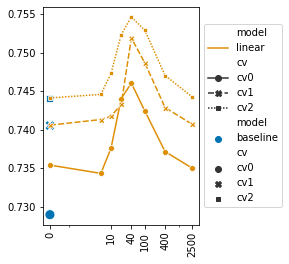

In [22]:
gs_linear = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=[
        "210520_LINEAR_BASELINE_MAX_NODES_PATIENT_1_BUSCH",
        "210520_LINEAR_MAX_NODES_PATIENT_1_BUSCH",
        "210521_LINEAR_MAX_NODES_PATIENT_1_BUSCH"
    ],
    lateral_resolution=0.5
)
gs_linear.load_gs()

gs_linear.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="model",
    graph_model_class='linear',
    baseline_model_class='linear_baseline',
    rename_levels = [
        ("model", {
            "LINEAR_MAX_NODES_PATIENT_1": "linear",
            "LINEAR_BASELINE_MAX_NODES_PATIENT_1": "baseline",
        })
    ],
    plot_mode = 'lineplot',
    palette = {"baseline": "C0", "linear": "C1"},
    xticks=[ 0,  10, 40, 100, 400, 2500],
)

# Encoder-decoder NCEM models

## Figure 3 (b): Nonlinear models of spatial dependencies of expression states.

210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH: loaded 72 runs with 3-fold cross validation


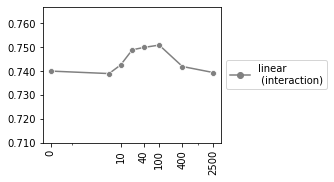

In [23]:
gs_interaction = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=["210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH"],
    lateral_resolution=0.5
)
gs_interaction.load_gs()
gs_interaction.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="model",
    graph_model_class='interactions',
    baseline_model_class='interactions_baseline',
    rename_levels = [
        ("model", {
            "INTERACTIONS_MAX_NODES_PATIENT_1": "linear \n (interaction)",
        })
    ],
    figsize=(4., 2.5),
    yaxis_limit=(0.710, 0.767),
    plot_mode = 'mean_lineplot',
    xticks=[ 0, 10, 40, 100, 400, 2500],
)

210302_LVMNP_NONE_NODES_PATIENT_1_BUSCH: loaded 768 runs with 3-fold cross validation
210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH: loaded 452 runs with 3-fold cross validation
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_MAX_NODES_PATIENT_1'], given was ['LVM

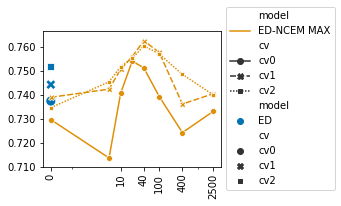

In [24]:
gs_ed_ncem_max = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=[
        "210302_LVMNP_NONE_NODES_PATIENT_1_BUSCH",
        "210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH",
    ],
    lateral_resolution=0.5
)
gs_ed_ncem_max.load_gs()
gs_ed_ncem_max.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="model",
    graph_model_class='clvmnp',
    baseline_model_class='lvmnp',
    rename_levels = [
        ("model", {
            "LVMNP_NONE_NODES_PATIENT_1": "ED",
            "CLVMNP_MAX_NODES_PATIENT_1": "ED-NCEM MAX",
        })
    ],
    figsize=(4., 2.5),
    yaxis_limit=(0.710, 0.767),
    plot_mode = 'lineplot',
    palette = {"ED": "C0", "ED-NCEM MAX": "C1", "ED-NCEM GCN": "C2"},
    xticks=[ 0, 10, 40, 100, 400, 2500],
)

210302_LVMNP_NONE_NODES_PATIENT_1_BUSCH: loaded 768 runs with 3-fold cross validation
210303_CLVMNP_GCN_NODES_PATIENT_1_BUSCH: loaded 64 runs with 3-fold cross validation
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMNP_NONE_NODES_PATIENT_1']
subset was empty, available values for model are ['CLVMNP_GCN_NODES_PATIENT_1'], given was ['LVMN

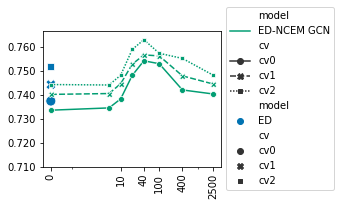

In [25]:
gs_ed_ncem_gcn = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=[
        "210302_LVMNP_NONE_NODES_PATIENT_1_BUSCH",
        "210303_CLVMNP_GCN_NODES_PATIENT_1_BUSCH",
    ],
    lateral_resolution=0.5
)
gs_ed_ncem_gcn.load_gs()



gs_ed_ncem_gcn.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="model",
    graph_model_class='clvmnp',
    baseline_model_class='lvmnp',
    rename_levels = [
        ("model", {
            "LVMNP_NONE_NODES_PATIENT_1": "ED",
            "CLVMNP_GCN_NODES_PATIENT_1": "ED-NCEM GCN",
        })
    ],
    figsize=(4., 2.5),
    yaxis_limit=(0.710, 0.767),
    plot_mode = 'lineplot',
    palette = {"ED": "C0", "ED-NCEM MAX": "C1", "ED-NCEM GCN": "C2"},
    xticks=[ 0, 10, 40, 100, 400, 2500],
)

## Figure 3 (d): Nonlinear models of spatial dependencies of expression states.

In [26]:
ed_ncem_max = ncem.interpretation.InterpreterEDncem()
ed_ncem_max.load_model(
    results_path=grid_search_dir,
    gs_id="210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH",
    cv_idx=1,
    lateral_resolution=0.5
)
ed_ncem_max.get_data_again(data_path=datadir + 'busch/', data_origin="jarosch")
ed_ncem_max.split_data_byidx_again(cv_idx=1)
ed_ncem_max.init_model_again()
ed_ncem_max.load_weights_again()
ed_ncem_max.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 6460, 1, 12, 1)})

210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH: loaded 452 runs with 3-fold cross validation
cross-validation selected: cv1
loaded model 210303_clvmnp_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md5_tk4_n100_fsstandard_ldi2_ei4_di5_ede1_dde0_dr1_l22_l11_COND_cde1_cbTrue_cdi0_cdr1_cnh1_cl22
Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Node_type added to categorical predictor matrix
Mean of mean node degree per images across images: 103.034519
cross-validation selected: cv1
setting reinitialized layer weights to layer weights from model 210303_clvmnp_max_nodes_patient_1_busch_adam_lr1_agrFalse_bsS_md5_tk4_n100_fsstandard_ldi2_ei4_di5_ede1_dde0_dr1_l22_l11_COND_cde1_cbTrue_cdi0_cdr1_cnh1_cl22


  0%|          | 0/2 [00:00<?, ?it/s]

ATTENTION: specifying reinit_n_eval will change class argument n_eval_nodes_per_graph from 100 to 1


100%|██████████| 2/2 [00:32<00:00, 16.22s/it]


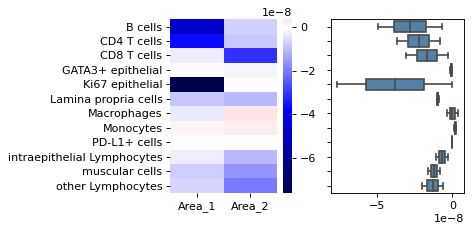

In [27]:
saliencies = ed_ncem_max.target_cell_saliencies(target_cell_type='CD8 T cells')
ed_ncem_max.plot_target_cell_saliencies(
    saliencies=saliencies, multiindex=False, figsize=(6,3), width_ratios=[1,1], fontsize=10
)

## Supp. Fig. 11 (b): Length scales of dependencies for different target cell-types.

210302_LVMNP_NONE_NODES_PATIENT_1_BUSCH: loaded 768 runs with 3-fold cross validation
210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH: loaded 452 runs with 3-fold cross validation
210303_CLVMNP_GCN_NODES_PATIENT_1_BUSCH: loaded 64 runs with 3-fold cross validation


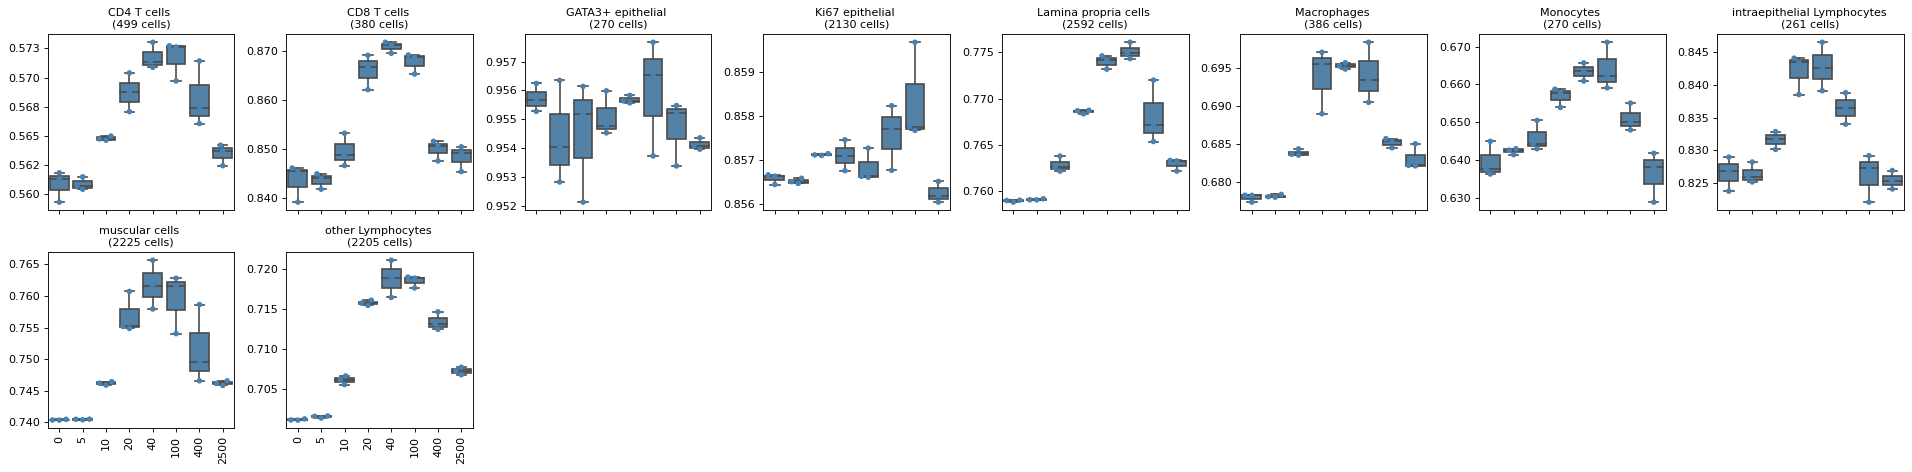

In [28]:
gs_ed_ncem = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=[
        "210302_LVMNP_NONE_NODES_PATIENT_1_BUSCH",
        "210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH",
        "210303_CLVMNP_GCN_NODES_PATIENT_1_BUSCH"
    ],
    lateral_resolution=0.5
)
gs_ed_ncem.load_gs()

gs_ed_ncem.load_target_cell_evaluation()
gs_ed_ncem.plot_target_cell_evaluation(
    metric_show="r_squared_linreg",
    metric_select="r_squared_linreg",
    param_x="um_radius",
)

## Paired t-test between baseline model and best spatial model

In [29]:
test_id_ed = gs_ed_ncem.get_best_model_id(
    subset_hyperparameters=[("model", "LVMNP_NONE_NODES_PATIENT_1")],
)
ed_test_r2 = np.array(
    gs_ed_ncem.summary_table[gs_ed_ncem.summary_table["run_id"] ==test_id_ed]['test_r_squared_linreg']
)
test_id_ed_ncem_max = gs_ed_ncem.get_best_model_id(
    subset_hyperparameters=[("model", "CLVMNP_MAX_NODES_PATIENT_1")],
)
ed_ncem_max_test_r2 = np.array(
    gs_ed_ncem.summary_table[gs_ed_ncem.summary_table["run_id"] ==test_id_ed_ncem_max]['test_r_squared_linreg']
)

test_id_ed_ncem_gcn = gs_ed_ncem.get_best_model_id(
    subset_hyperparameters=[("model", "CLVMNP_GCN_NODES_PATIENT_1")],
)
ed_ncem_gcn_test_r2 = np.array(
    gs_ed_ncem.summary_table[gs_ed_ncem.summary_table["run_id"] ==test_id_ed_ncem_gcn]['test_r_squared_linreg']
)

print('ED-NCEM MAX:', ttest_rel(ed_ncem_max_test_r2, ed_test_r2))
print('ED-NCEM GCN:', ttest_rel(ed_ncem_gcn_test_r2, ed_test_r2))

ED-NCEM MAX: Ttest_relResult(statistic=2.1671744697268993, pvalue=0.1625377655945355)
ED-NCEM GCN: Ttest_relResult(statistic=6.024293600590916, pvalue=0.02646524263361761)


## Unpaired t-test between interaction model and best spatial model

In [30]:
test_id_interaction = gs_interaction.get_best_model_id(
    subset_hyperparameters=[("model", "INTERACTIONS_MAX_NODES_PATIENT_1")]
)
interaction_test_r2 = np.array(
    gs_interaction.summary_table[gs_interaction.summary_table["run_id"]==test_id_interaction]['test_r_squared_linreg']
)
print('ED-NCEM MAX:', ttest_ind(ed_ncem_max_test_r2, interaction_test_r2))
print('ED-NCEM GCN:', ttest_ind(ed_ncem_gcn_test_r2, interaction_test_r2))

ED-NCEM MAX: Ttest_indResult(statistic=1.8321653286323851, pvalue=0.1408730802006101)
ED-NCEM GCN: Ttest_indResult(statistic=1.5256669763521886, pvalue=0.20178838627333306)


# Conditional variational autoencoder NCEM

## Figure 4: Modelling intrinsic and extrinsic variation in deep latent variable models.

In [31]:
gs_overview = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=[
        "210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH",
        "210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH",
        "210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH",
        "210303_CLVMNP_GCN_NODES_PATIENT_1_BUSCH",
        "210427_VAE_NONE_TARGET_CELL_PATIENT_1_BUSCH",
        "210430_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH",
        "210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH"
    ],
    lateral_resolution=0.5
)
gs_overview.load_gs()

210414_INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1_BUSCH: loaded 9 runs with 3-fold cross validation
210414_INTERACTIONS_MAX_NODES_PATIENT_1_BUSCH: loaded 72 runs with 3-fold cross validation
210303_CLVMNP_MAX_NODES_PATIENT_1_BUSCH: loaded 452 runs with 3-fold cross validation
210303_CLVMNP_GCN_NODES_PATIENT_1_BUSCH: loaded 64 runs with 3-fold cross validation
210427_VAE_NONE_TARGET_CELL_PATIENT_1_BUSCH: loaded 4 runs with 3-fold cross validation
210430_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded 23 runs with 3-fold cross validation
210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded 1543 runs with 3-fold cross validation


No handles with labels found to put in legend.


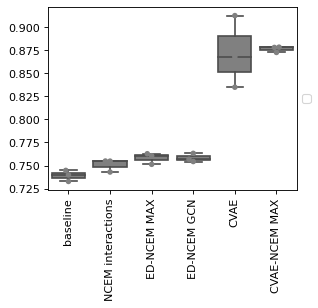

In [32]:
gs_overview.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="model",
    param_hue="data_set",
    graph_model_class='',
    baseline_model_class='',
    rotate_xticks=True,
    rename_levels = [
        ("model", {
            "LINEAR_MAX_NODES_PATIENT_1": "NCEM linear",
            "LINEAR_BASELINE_MAX_NODES_PATIENT_1": "baseline",
            "INTERACTIONS_MAX_NODES_PATIENT_1": "NCEM interactions",
            "CLVMNP_MAX_NODES_PATIENT_1": "ED-NCEM MAX",
            "CLVMNP_GCN_NODES_PATIENT_1": "ED-NCEM GCN",
            "CVAE_MAX_TARGET_CELL_PATIENT_1": "CVAE-NCEM MAX",
            "INTERACTIONS_BASELINE_NONE_NODES_PATIENT_1": "baseline",
            "LVMNP_NONE_NODES_PATIENT_1": "ED",
            "VAE_NONE_TARGET_CELL_PATIENT_1": "CVAE",
        })
    ],
    figsize=(5., 3.),
    color='grey',
)

## Posterior resampling - muscular cels

210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded 1543 runs with 3-fold cross validation
210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded posterior sampling as seperate model (1543 runs with 3-fold cross validation)


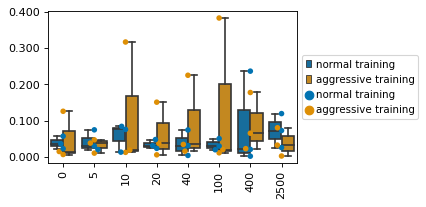

In [33]:
gs_vae = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=["210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH"],
    lateral_resolution=0.5
)
gs_vae.load_gs(add_posterior_sampling_model=True)

gs_vae.summary_table = gs_vae.summary_table[(
    (gs_vae.summary_table['target_cell_type'] == 'muscular cells') & (gs_vae.summary_table['posterior_sampling_eval'] == True)
)]

gs_vae.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="aggressive",
    graph_model_class='cvae posterior sampling',
    baseline_model_class='vae posterior sampling',
    rename_levels = [
        ("aggressive", {
            True: "aggressive training",
            False: "normal training",
        })
    ],
    figsize=(5, 2.5),
    plot_mode = 'boxplot',
)

In [34]:
cvae = ncem.interpretation.InterpreterCVAEncem()
cvae.load_model(
    results_path=grid_search_dir,
    gs_id="210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH",
    cv_idx=1,
    model_id='210527_cvae_max_target_cell_patient_1_busch_adam_lr2_agrTrue_predecFalse_bsS_md5_tk4_n10_fsstandard_ldi2_ei5_di4_ede1_dde1_dr1_l22_l11_COND_cde1_cbTrue_cdi0_cdr1_cnh1_cl22_muscu',
)
cvae.get_data_again(data_path=datadir + "busch/", data_origin="jarosch")
cvae.split_data_byidx_again(cv_idx=1)

cvae.init_model_again()
cvae.load_weights_again()
cvae.reinitialize_model(changed_model_kwargs={'input_shapes': (12, 19, 6460, 1, 12, 1)})

210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded 1543 runs with 3-fold cross validation
cross-validation selected: cv1
loaded model 210527_cvae_max_target_cell_patient_1_busch_adam_lr2_agrTrue_predecFalse_bsS_md5_tk4_n10_fsstandard_ldi2_ei5_di4_ede1_dde1_dr1_l22_l11_COND_cde1_cbTrue_cdi0_cdr1_cnh1_cl22_muscu
Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Node_type added to categorical predictor matrix
Mean of mean node degree per images across images: 103.034519
cross-validation selected: cv1

Two checkpoint references resolved to different objects (<ncem.models.layers.layer_stacks_lvm.CondEncoder object at 0x7f2d77f0f040> and <ncem.models.layers.layer_stacks_lvm.CondDecoder object at 0x7f2d77ffb520>).

Two checkpoint references resolved to different objects (<ncem.models.layers.layer_stacks_lvm.CondDecoder object at 0x7f2d77ffb520> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2d7807dcd0>).

Two checkpoint references resolved to different objects (<ncem.models.layers.output_layers.GaussianOutput object at 0x7f2d78020550> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2d7803e610>).
setting reinitialized layer weights to layer weights from model 210527_cvae_max_target_c

In [35]:
adata, log_pval, fold_change = cvae.compute_latent_space_cluster_enrichment(
    image_key='Area_1',
    target_cell_type='muscular',
    n_neighbors=250,
    n_pcs=None
)

ATTENTION: specifying reinit_n_eval will change class argument n_eval_nodes_per_graph from 10 to 1
n cells:  1149
muscular 0    315
muscular 1    287
muscular 2    238
muscular 3    183
muscular 4    126
Name: substates, dtype: int64


... storing 'target_cell' as categorical


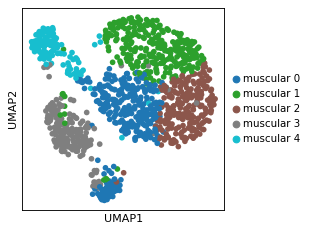

In [36]:
plt.ioff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
sc.pl.umap(adata, color=['substates'], ax=ax, show=False, palette='tab10', title='')
plt.tight_layout()
plt.show()

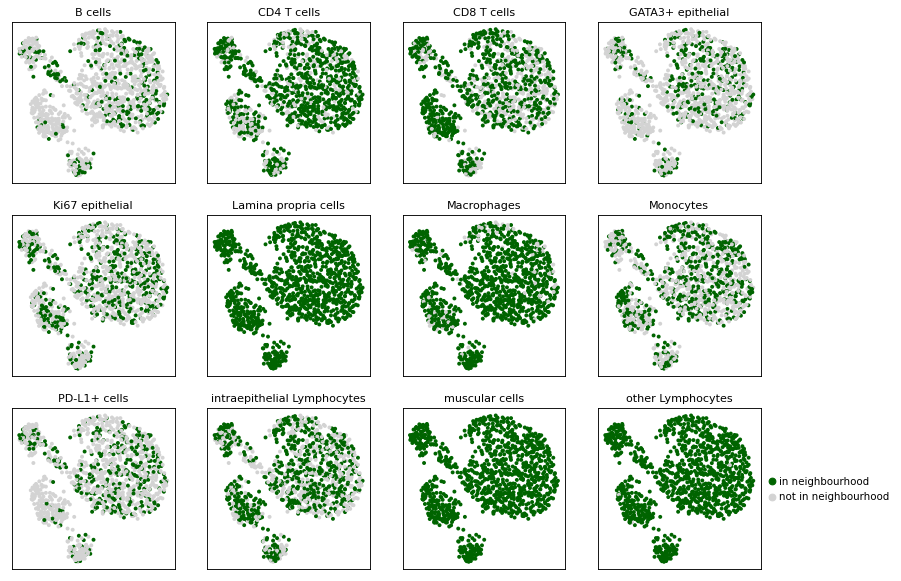

In [37]:
filter_titles = list(cvae.data.celldata.uns['node_type_names'].values())
for i, x in enumerate(filter_titles):
    adata.uns[f"{x}_colors"] = ['darkgreen', 'lightgrey']
plt.ioff()
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12,9), )
N = len(filter_titles)
axs = axs.flat
for ax in axs[N:]:
    ax.remove()
ax = axs[:N]

for i, x in enumerate(filter_titles[:-1]):
    sc.pl.umap(
        adata,
        color=f"{x}",
        title=x,
        show=False,
        size=50,
        legend_loc='None',
        ax=ax[i]
    )
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
sc.pl.umap(
    adata,
    color=f"{filter_titles[-1]}",
    title=filter_titles[-1],
    show=False,
    size=50,
    ax=ax[N-1]
)
ax[N-1].set_xlabel('')
ax[N-1].set_ylabel('')
# Save, show and return figure.
plt.show()

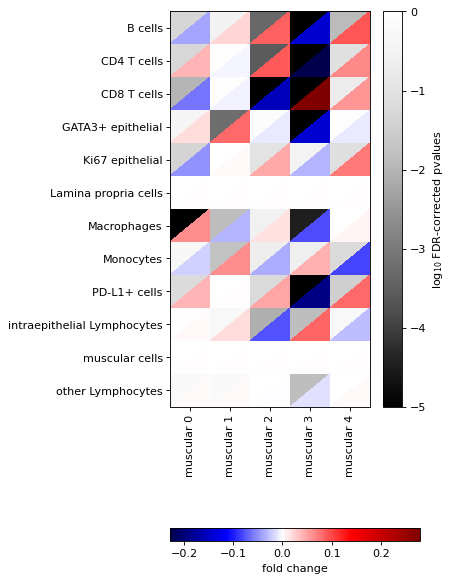

In [38]:
cvae.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    pad=0.2
)

## Posterior resampling - Lamina propria cels

210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded 1543 runs with 3-fold cross validation
210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH: loaded posterior sampling as seperate model (1543 runs with 3-fold cross validation)


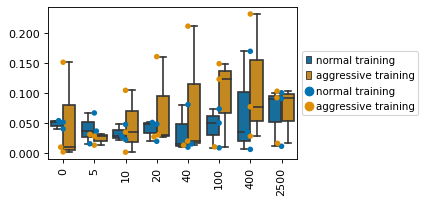

In [39]:
gs_vae = ncem.train.GridSearchContainer(
    grid_search_dir, 
    gs_ids=["210527_CVAE_MAX_TARGET_CELL_PATIENT_1_BUSCH"],
    lateral_resolution=0.5
)
gs_vae.load_gs(add_posterior_sampling_model=True)

gs_vae.summary_table = gs_vae.summary_table[(
    (gs_vae.summary_table['target_cell_type'] == 'Lamina propria cells') & (gs_vae.summary_table['posterior_sampling_eval'] == True)
)]

gs_vae.plot_best_model_by_hyperparam(
    partition_show="test",
    metric_show="r_squared_linreg",
    partition_select="val",
    metric_select="r_squared_linreg",
    param_x="um_radius",
    param_hue="aggressive",
    graph_model_class='cvae posterior sampling',
    baseline_model_class='vae posterior sampling',
    rename_levels = [
        ("aggressive", {
            True: "aggressive training",
            False: "normal training",
        })
    ],
    figsize=(5, 2.5),
    plot_mode = 'boxplot',
)